In [13]:
import numpy as np
import torch.distributions as distrib
import torch.distributions.transforms as transform
from matplotlib import pyplot as plt
import torch
from torch.autograd import Variable
from torch import optim
from torch import nn

In [66]:
def sample_boom(batch_size):
    x2_dist = distrib.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample((batch_size,))
    x1 = distrib.Normal(loc=.25 * torch.square(x2_samples), scale=torch.ones(batch_size, dtype=torch.float32))
    x1_samples = x1.sample()
    return torch.stack([x1_samples, x2_samples], axis=1)

In [48]:
# need a wrapper class so we can optimize parameters via SGD

class Flow(transform.Transform, nn.Module):
    
    domain = distrib.constraints.real
    codomain = distrib.constraints.real
    bijective = True
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)


# define bijector for LeakyReLU
class LeakyReLU(Flow):
    
    def __init__(self, alpha=1.0, validate_args=False, name="leaky_relu"):
        super().__init__()
        
        self.alpha = nn.Parameter(torch.tensor([float(alpha)]), requires_grad=True)
        self.init_parameters()

    def _call(self, x):
        return torch.where(torch.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return torch.where(torch.greater_equal(y, 0), y, 1. / self.alpha * y)

    def log_abs_det_jacobian(self, x, y):
        # event_dims = y.event_shape
        I = torch.ones_like(y)
        J_inv = torch.where(torch.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = torch.log(torch.abs(J_inv))
        return log_abs_det_J_inv.sum(axis=-1)
    
class AffineTrans(Flow, distrib.AffineTransform):
    
    def __init__(self, loc=0, scale=1.0, name="affine_trans"):
        Flow.__init__(self)
        distrib.AffineTransform.__init__(self, loc=loc, scale=scale)
        self.init_parameters()

In [60]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(AffineTrans())
#             biject.append(LeakyReLU())
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, x):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            x = self.bijectors[b](x)
        return x
    
# Create normalizing flow
base_density = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

flow = NormalizingFlow(dim=2, flow_length=6, density=base_density)

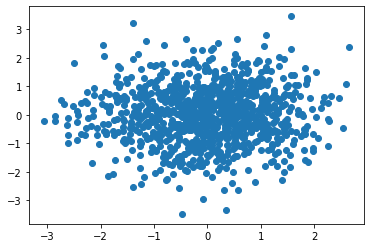

In [61]:
zk = flow.forward(base_density.sample((1000,))).detach().numpy()

plt.scatter(zk[:,0], zk[:,1]) 

In [64]:
boom_samples = sample_boom(1000)

# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

loss = -flow.final_density.log_prob(boom_samples).mean()

In [70]:
flow.final_density.log_prob(boom_samples)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [67]:
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from target distribution
    boom_samples = sample_boom(512)

    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = -flow.final_density.log_prob(boom_samples).mean()
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    
    print(loss_v)
    
    
#     if (it % 1000 == 0):
#         print('Loss (it. %i) : %f'%(it, loss_v.item()))
#         # Draw random samples
#         samples = ref_distrib.sample((int(1e5), ))
#         # Evaluate flow and plot
#         zk, _ = flow(samples)
#         zk = zk.detach().numpy()
#         plt.subplot(3,4,id_figure)
#         plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
#         plt.title('Iter.%i'%(it), fontsize=15);
#         id_figure += 1

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Simple Test

In [ ]:
base_dist = distrib.Normal(0,1)
flow = distrib.TransformedDistribution(base_dist, [transform.AffineTransform(5,1)])

samples = base_dist.sample((10,))

loss = -flow.log_prob(samples).mean()

loss.backward()